<a href="https://colab.research.google.com/github/srikarpavan/python/blob/master/projectcancerclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Step 1: Import Modules*

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
from scipy.misc import imresize, imread
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

Using TensorFlow backend.


*Step 2: Explore Data*

In [0]:
imagePatches = glob('C:/Users/pavan/OneDrive/Documents/GitHub/python/MLK/input/IDC_regular_ps50_idx5/**/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

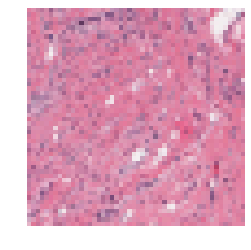

In [0]:
image_name = "C:/Users/pavan/OneDrive/Documents/GitHub/python/MLK/input/IDC_regular_ps50_idx5/9135/1/9135_idx5_x1501_y2101_class1.png" #Image to be used as query
def plotImage(image_location):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (50,50))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotImage(image_name)

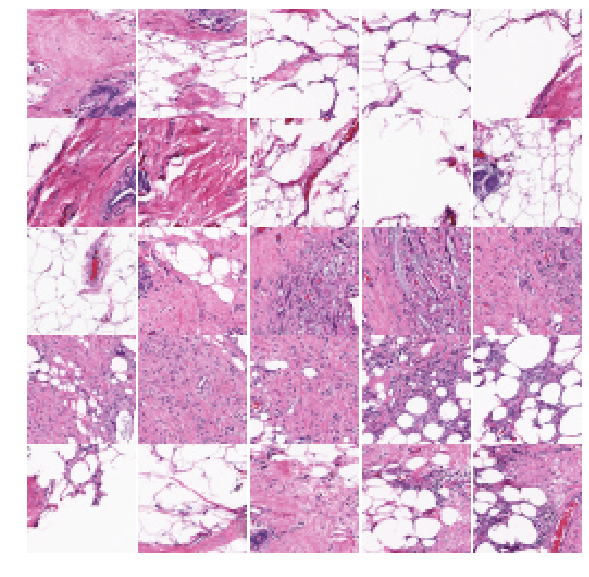

In [0]:
# Plot Multiple Images
bunchOfImages = imagePatches
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in bunchOfImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (50, 50)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

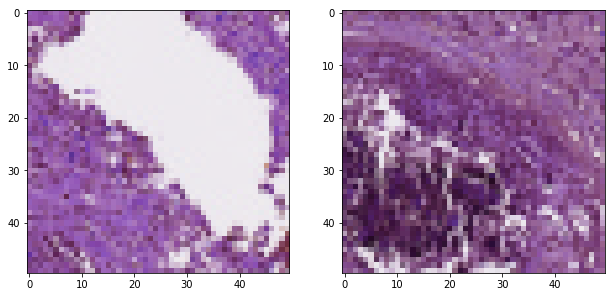

In [0]:
def randomImages(a):
    r = random.sample(a, 10)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    #plt.subplot(133)
   # plt.imshow(cv2.imread(r[2])); 
    
randomImages(imagePatches)

*Step 3: Preprocess Data*

In [0]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)
print("IDC(-)\n\n",classZero[0:5],'\n')
print("IDC(+)\n\n",classOne[0:5])

IDC(-)

 ['C:/Users/laksh\\Documents/Python projects/MLK/input/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1001_class0.png', 'C:/Users/laksh\\Documents/Python projects/MLK/input/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1051_class0.png', 'C:/Users/laksh\\Documents/Python projects/MLK/input/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1101_class0.png', 'C:/Users/laksh\\Documents/Python projects/MLK/input/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1151_class0.png', 'C:/Users/laksh\\Documents/Python projects/MLK/input/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1201_class0.png'] 

IDC(+)

 ['C:/Users/laksh\\Documents/Python projects/MLK/input/IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x501_y351_class1.png', 'C:/Users/laksh\\Documents/Python projects/MLK/input/IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x501_y401_class1.png', 'C:/Users/laksh\\Documents/Python projects/MLK/input/IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y301_class1.png', 'C:/User

In [0]:
def proc_images(lowerIndex,upperIndex):
    
  ##  Returns two arrays: 
    #    x is an array of resized images
     #   y is an array of labels
     
    x = []
    y = []
    WIDTH = 50
    HEIGHT = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

In [0]:
X,Y = proc_images(0,10000)
df = pd.DataFrame()
df["images"]=X
df["labels"]=Y
X2=df["images"]
Y2=df["labels"]
X2=np.array(X2)
imgs0=[]
imgs1=[]
imgs0 = X2[Y2==0] # (0 = no IDC, 1 = IDC)
imgs1 = X2[Y2==1] 

In [0]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X2,Y2)

Total number of images: 10000
Number of IDC(-) Images: 7541
Number of IDC(+) Images: 2459
Percentage of positive images: 24.59%
Image shape (Width, Height, Channels): (50, 50, 3)


In [0]:
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
print(df.head(10))
print("")
print(dict_characters)

                                              images  labels
0  [[[206, 164, 226], [196, 154, 224], [211, 175,...       0
1  [[[197, 150, 219], [201, 158, 217], [205, 173,...       0
2  [[[249, 245, 248], [248, 246, 248], [253, 246,...       0
3  [[[249, 247, 249], [249, 247, 249], [249, 247,...       0
4  [[[237, 231, 241], [245, 242, 246], [235, 222,...       0
5  [[[248, 246, 248], [248, 246, 248], [248, 246,...       0
6  [[[175, 120, 212], [145, 88, 175], [132, 72, 1...       0
7  [[[87, 38, 142], [120, 94, 165], [195, 180, 21...       0
8  [[[235, 228, 240], [242, 240, 246], [252, 244,...       0
9  [[[238, 223, 242], [239, 235, 241], [250, 245,...       0

{0: 'IDC(-)', 1: 'IDC(+)'}


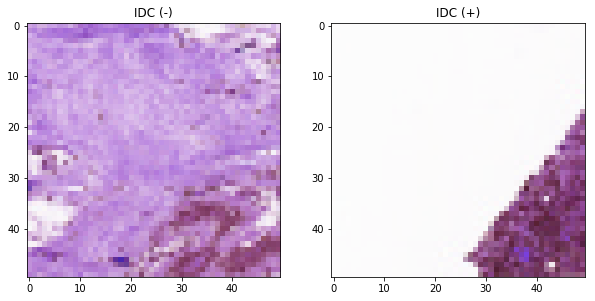

In [0]:
def plotOne(a,b):
    """
    Plot one numpy array
    """
    plt.subplot(1,2,1)
    plt.title('IDC (-)')
    plt.imshow(a[0])
    plt.subplot(1,2,2)
    plt.title('IDC (+)')
    plt.imshow(b[0])
plotOne(imgs0, imgs1) 

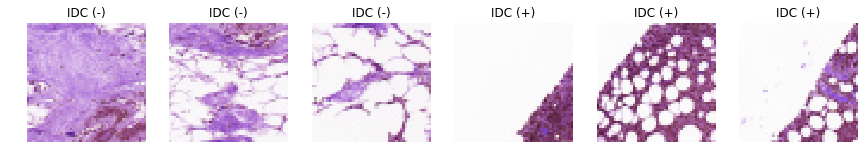

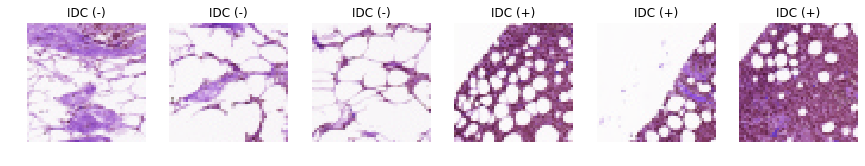

In [0]:
def plotTwo(a,b): 
    """
    Plot a bunch of numpy arrays sorted by label
    """
    for row in range(3):
        plt.figure(figsize=(20, 10))
        for col in range(3):
            plt.subplot(1,8,col+1)
            plt.title('IDC (-)')
            plt.imshow(a[0+row+col])
            plt.axis('off')       
            plt.subplot(1,8,col+4)
            plt.title('IDC (+)')
            plt.imshow(b[0+row+col])
            plt.axis('off')
plotTwo(imgs0, imgs1) 

The data is scaled from 0 to 256 but we want it to be scaled from 0 to 1. This will make the data compatible with a wide variety of different classification algorithms.  We also want to set aside 20% of the data for testing. This will make the trained model less prone to overfitting.  And finally, we will use an oversampling strategy to deal with the imbalanced class sizes.

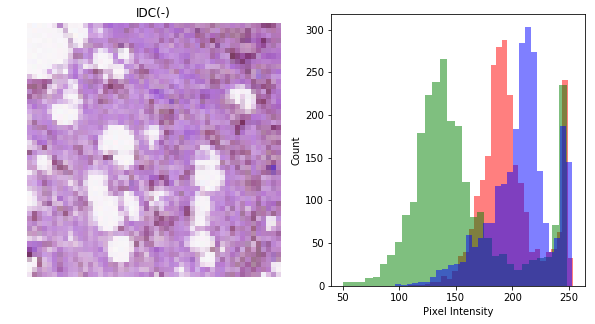

In [0]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('IDC(+)' if Y[1] else 'IDC(-)')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X2[100])

In [0]:
X=np.array(X)
X=X/255.0 #normalization

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Reduce Sample Size for DeBugging
X_train = X_train[0:300000] 
Y_train = Y_train[0:300000]
X_test = X_test[0:300000] 
Y_test = Y_test[0:300000]

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (8000, 50, 50, 3)
Testing Data Shape: (2000, 50, 50, 3)


In [0]:
# Encode labels to hot vectors 
Y_trainHot = to_categorical(Y_train, num_classes = 2)
Y_testHot = to_categorical(Y_test, num_classes = 2)

{0: 'IDC(-)', 1: 'IDC(+)'}


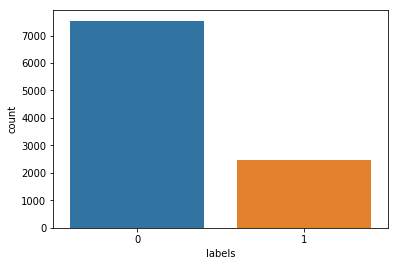

In [0]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

X_train Shape:  (8000, 50, 50, 3)
X_test Shape:  (2000, 50, 50, 3)
X_trainFlat Shape:  (8000, 7500)
X_testFlat Shape:  (2000, 7500)
X_trainRos Shape:  (3948, 7500)
X_trainRosReshaped Shape:  (3948, 50, 50, 3)
{0: 'IDC(-)', 1: 'IDC(+)'}


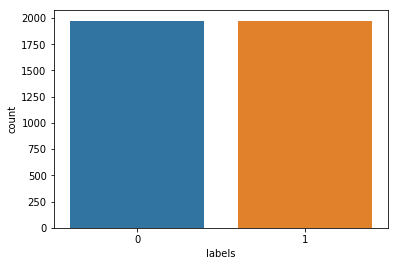

In [0]:
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
print("X_train Shape: ",X_train.shape)
print("X_test Shape: ",X_test.shape)
print("X_trainFlat Shape: ",X_trainFlat.shape)
print("X_testFlat Shape: ",X_testFlat.shape)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

ros = RandomUnderSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)
#print("X_train: ", X_train.shape)
#print("X_trainFlat: ", X_trainFlat.shape)
#print("X_trainRos Shape: ",X_trainRos.shape)
#print("X_testRos Shape: ",X_testRos.shape)
#print("Y_trainRosHot Shape: ",Y_trainRosHot.shape)
#print("Y_testRosHot Shape: ",Y_testRosHot.shape)

for i in range(len(X_trainRos)):
    height, width, channels = 50,50,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
print("X_trainRos Shape: ",X_trainRos.shape)
print("X_trainRosReshaped Shape: ",X_trainRosReshaped.shape)

for i in range(len(X_testRos)):
    height, width, channels = 50,50,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
#print("X_testRos Shape: ",X_testRos.shape)
#print("X_testRosReshaped Shape: ",X_testRosReshaped.shape)

dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

*Step 4: Define Helper Functions for the Classification Task*

In [0]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
print("Old Class Weights: ",class_weight)
from sklearn.utils import class_weight
class_weight2 = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight2)

Old Class Weights:  [0.66379024 2.02634245]
New Class Weights:  [1. 1.]


In [0]:
# Helper Functions  Learning Curves and Confusion Matrix

class MetricsCheckpoint(Callback):
    ##Callback that saves metrics after each epoch
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    ##This function prints and plots the confusion matrix.
    ##Normalization can be applied by setting `normalize=True`.
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [0]:
#runLogisticRegression
def runLogisticRegression(a,b,c,d):
    """Run LogisticRegression w/ Kfold CV"""
    model = LogisticRegression()
    model.fit(a,b)
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('LogisticRegression - Training set accuracy: %s (%s)' % (mean, stdev))
    print('')
runLogisticRegression(X_trainFlat, Y_train, X_testFlat, Y_test)

C:\Users\laksh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\laksh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\laksh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\laksh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\laksh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

LogisticRegression - Training set accuracy: 0.8365 (0.020377683872314832)



In [0]:
# Compare Performance of Classification Algorithms
def compareABunchOfDifferentModelsAccuracy(a,b,c,d):
   
    print('')
    print('Compare Multiple Classifiers:')
    print('')
    print('K-Fold Cross-Validation Accuracy:')
    print('')
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('SVM', SVC()))
    models.append(('LSVM', LinearSVC()))
    models.append(('GNB', GaussianNB()))
    models.append(('DTC', DecisionTreeClassifier()))
         
    resultsAccuracy = []
    names = []
    for name, model in models:
        model.fit(a, b)
        kfold = model_selection.KFold(n_splits=10)
        accuracy_results = model_selection.cross_val_score(model, c, d, cv=kfold, scoring='accuracy')
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage)  
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: Accuracy')
    ax = fig.add_subplot(111)
    plt.boxplot(resultsAccuracy)
    ax.set_xticklabels(names)
    ax.set_ylabel('Cross-Validation: Accuracy Score')
    plt.show()
    return
compareABunchOfDifferentModelsAccuracy(X_trainFlat, Y_train, X_testFlat, Y_test)


def defineModels():
    print('')
    print('LR = LogisticRegression')
    print('RF = RandomForestClassifier')
    print('KNN = KNeighborsClassifier')
    print('SVM = Support Vector Machine SVC')
    print('LSVM = LinearSVC')
    print('GNB = GaussianNB')
    print('DTC = DecisionTreeClassifier')
    #print('GBC = GradientBoostingClassifier')
    #print('LDA = LinearDiscriminantAnalysis')
    print('')
    return
defineModels()


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:



C:\Users\laksh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\laksh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\laksh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\laksh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\laksh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

LR: 0.836500 (0.020378)


C:\Users\laksh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF: 0.844500 (0.027699)
KNN: 0.851000 (0.031369)


C:\Users\laksh\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\laksh\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\laksh\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\laksh\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

SVM: 0.853000 (0.027677)


C:\Users\laksh\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\laksh\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\laksh\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\laksh\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\laksh\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

KeyboardInterrupt: 

*Step 5: Evaluate Classification Models*

Epoch 1/8
124/123 [==============================] - 9s 72ms/step - loss: 0.6295 - acc: 0.6657 - val_loss: 0.6571 - val_acc: 0.5000
Epoch 2/8
124/123 [==============================] - 10s 77ms/step - loss: 0.5032 - acc: 0.7750 - val_loss: 0.3968 - val_acc: 0.8278
Epoch 3/8
124/123 [==============================] - 10s 78ms/step - loss: 0.4400 - acc: 0.8125 - val_loss: 0.3821 - val_acc: 0.8258
Epoch 4/8
124/123 [==============================] - 9s 76ms/step - loss: 0.4056 - acc: 0.8269 - val_loss: 0.3409 - val_acc: 0.8443
Epoch 5/8
124/123 [==============================] - 9s 76ms/step - loss: 0.4038 - acc: 0.8269 - val_loss: 0.3900 - val_acc: 0.8237
Epoch 6/8
124/123 [==============================] - 9s 76ms/step - loss: 0.3939 - acc: 0.8356 - val_loss: 0.3340 - val_acc: 0.8505
Epoch 7/8
124/123 [==============================] - 10s 81ms/step - loss: 0.3914 - acc: 0.8393 - val_loss: 0.3321 - val_acc: 0.8598
Epoch 8/8
124/123 [==============================] - 10s 77ms/step - loss

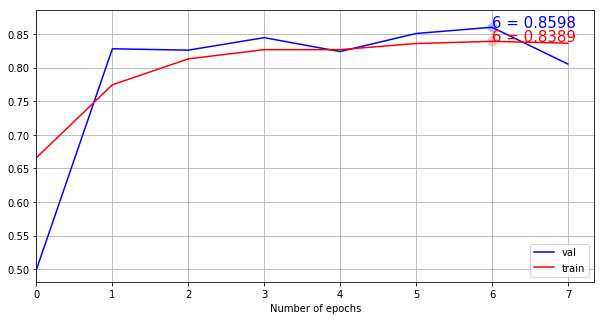

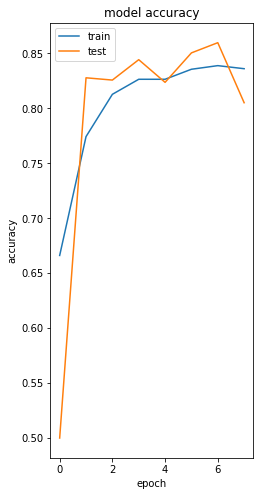

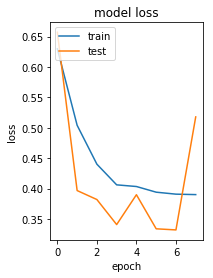

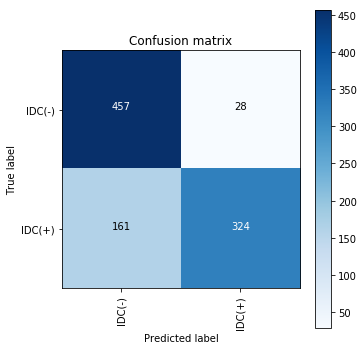

In [0]:
def runKerasCNNAugment(a,b,c,d,e,f):
    
    batch_size = 128
    num_classes = 2
    epochs = 8
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs,class_weight=f, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)